# Tech Stack Analysis and Trends in Web Development

## Objective

The primary goal of this project is to explore and uncover relationships between commonly used **frontend** and **backend** technologies in modern web application development. By leveraging unsupervised machine learning techniques, the project aims to identify:

- Common pairings of frontend and backend frameworks (e.g., React with Node.js or Vue with Laravel).
- Unique clusters that represent specific tech stack trends or niche combinations.
- Patterns that differentiate modern tech stacks from legacy or specialized configurations.

## Motivation

Understanding these relationships can provide insights into:

- **Technology trends**: Which combinations are most prevalent in high-performing or scalable projects.
- **Developer ecosystems**: How developers pair technologies across domains and industries.
- **Decision-making**: Informing organizations about common and effective tech stack choices for their projects.

## Methodology Overview

To achieve the objective, the project follows a structured roadmap:

1. **Data Collection**: Tech stack data from sources like GitHub (e.g., `package.json`, `requirements.txt`).
2. **Feature Engineering**: Representation of frontend-backend technologies as co-occurrence vectors.
3. **Clustering and Dimensionality Reduction**: Applying algorithms like K-Means or DBSCAN to group tech stacks based on similarity.
4. **Visualization and Analysis**: Using heatmaps and cluster plots to illustrate relationships and trends.


# Data Collection

## Sources

The data for this project was gathered from various repositories and tech stack files to ensure coverage of both **frontend** and **backend** technologies. The primary focus was on obtaining structured files like:

- **`package.json`**: Captures dependencies for JavaScript-based projects, including libraries and frameworks for frontend and backend.
- **`requirements.txt`**: Lists Python dependencies, often including backend frameworks like Flask or Django.
- **Other Framework-Specific Files**: Files like `Dockerfile` or `.csproj` were included when available, to identify specific tools or runtime environments.

## Approach

1. **File Parsing**:

   - Extracted relevant data from tech stack definition files such as `dependencies` and `devDependencies` in `package.json`.
   - Focused on capturing libraries with a clear **frontend** or **backend** designation.

2. **Normalization**:

   - Standardized library names to account for variations (e.g., `react-dom` as part of React, or `express-session` as part of Express).
   - Removed duplicates and noise from the data.

3. **Filtering**:
   - Libraries unrelated to the core frontend-backend relationship (e.g., testing or build tools like `jest` or `webpack`) were filtered out during preprocessing to focus on actionable insights.
   - Retained essential frameworks and utility libraries directly tied to application logic or rendering.

## Key Stats

- **Total Entries**: The dataset includes tech stacks from X repositories.
- **Libraries Captured**: Over Y unique libraries were identified, spanning both frontend and backend technologies.

This dataset forms the basis for feature engineering and subsequent analysis in the notebook.


In [14]:
import requests
import pandas as pd
import numpy as np
import time
import os
from dotenv import load_dotenv
import json
import base64
import re
import ast

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# GitHub API Configuration
load_dotenv()
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
GITHUB_API_URL = "https://api.github.com"
HEADERS = {
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "X-GitHub-Api-Version": "2022-11-28",
}

In [15]:
# # Function to fetch repositories based on query
# def fetch_repositories(query, per_page=30, pages=1):
#     """
#     Fetch repositories from GitHub API based on a search query.
#     Parameters:
#         query (str): The search term for repositories.
#         per_page (int): Number of repositories per page (max 100).
#         pages (int): Number of pages to fetch.
#     Returns:
#         list: List of repository URLs.
#     """
#     repo_urls = []
#     for page in range(1, pages + 1):
#         url = f"{GITHUB_API_URL}/search/repositories?q={query}&per_page={per_page}&page={page}"
#         response = requests.get(url, headers=HEADERS)
#         if response.status_code == 200:
#             items = response.json().get("items", [])
#             for item in items:
#                 repo_urls.append(item["url"])
#         else:
#             print(f"Error: {response.status_code} - {response.text}")
#         # Rate limiting
#         time.sleep(2)
#     return repo_urls


# # Updated function to handle multiple dependency file types
# def fetch_multiple_files(url, filepaths):
#     """
#     Fetch the content of multiple files from a GitHub repository.
#     Parameters:
#         owner (str): Owner of the repository.
#         repo (str): Repository name.
#         filepaths (list): List of file paths (e.g., ['package.json', 'requirements.txt']).
#     Returns:
#         dict: Dictionary with file paths as keys and their content as values.
#     """
#     files_data = {}
#     for filepath in filepaths:
#         full_url = url + f"/contents/{filepath}"
#         response = requests.get(full_url, headers=HEADERS)
#         if response.status_code == 200:
#             file_data = response.json()
#             content = base64.b64decode(file_data["content"]).decode("utf-8")
#             if content:
#                 files_data[filepath] = content
#     return files_data


# # Example: Extend fetch_dependencies_from_repos to include multiple file types
# def fetch_dependencies_from_repos_extended(repos, filepaths):
#     """
#     Fetch multiple dependency files from repositories.
#     Parameters:
#         repos (list): List of repositories with 'owner' and 'name' keys.
#         filepaths (list): List of dependency files to fetch (e.g., ['package.json', 'requirements.txt']).
#     Returns:
#         list: List of dictionaries containing repo details and fetched file content.
#     """
#     results = []
#     for repo in repos:
#         files_data = fetch_multiple_files(repo, filepaths)
#         if files_data != {}:
#             results.append({"repo": repo, "data": files_data})
#     return results

In [16]:
# # Step 1: Define search query and fetch repositories
# print("Fetching repositories...")
# query = "web app"
# repo_urls = fetch_repositories(query, per_page=100, pages=10)
# repo_urls_df = pd.DataFrame(repo_urls, columns=["url"])
# repo_urls_df.to_csv("data/repository_urls.csv", index=False)
# print("data/repository_urls.csv saved")

# # Step 2: Fetch dependency files for each repository
# print("Fetching dependency files...")
# urls = pd.read_csv("data/repository_urls.csv")["url"].tolist()
# # JS, Python, PHP, Ruby, Go, Java, Elixir
# dependency_files = [
#     "package.json",
#     # "requirements.txt",
#     # "composer.json",
#     # "Gemfile",
#     # "go.mod",
#     # "pom.xml",
#     # "build.gradle",
#     # "mix.exs",
# ]
# dependencies_data = fetch_dependencies_from_repos_extended(urls, dependency_files)

# # Step 4: Save dependencies data to a file (dependencies.csv)
# dependencies_df = pd.DataFrame(dependencies_data)
# dependencies_df.to_csv("data/dependencies.csv", index=False)
# print("data/dependencies.csv saved")

# Data Preprocessing

The preprocessing step focuses on cleaning, structuring, and engineering features from the raw data collected. The goal is to create a clean and meaningful dataset for clustering, emphasizing relationships between **frontend** and **backend** libraries.

### 1. Normalization
- **Standardized Library Names**:
  - Unified naming conventions for libraries (e.g., `react-dom` mapped to `react`, `express-session` mapped to `express`).
  - Addressed case sensitivity and removed version-specific identifiers (e.g., `lodash@4.17.21` → `lodash`).

### 2. Filtering
- **Irrelevant Libraries**:
  - Excluded libraries not directly relevant to frontend-backend relationships, such as:
    - Testing tools (`jest`, `mocha`).
    - Build tools (`webpack`, `gulp`).
    - Style-related libraries (`styled-components`, `tailwindcss`).
- **Retained Core Frameworks**:
  - Focused on libraries fundamental to application logic, such as React, Angular, Vue (frontend) or Express, Django, Flask (backend).

### 3. Feature Engineering
- **One-Hot Encoding**:
  - Converted each tech stack into a binary vector, where each column represents a library and a value of `1` indicates its presence.
- **Frontend-Backend Pairing**:
  - Added composite features representing common pairs (e.g., `React-Express`, `Vue-Koa`).
  - Highlighted co-occurrence patterns within individual projects.

### 4. Handling Missing Data
- **Inferred Missing Frameworks**:
  - If a frontend framework was present but no backend was listed, inferred popular backend options (e.g., Node.js for React or Flask for Python-based libraries).
- **Dropped Incomplete Entries**:
  - Removed tech stacks missing critical information (e.g., neither frontend nor backend framework specified).

In [17]:
def extract_package_json(row):
    try:
        # Convert the string into a Python dictionary
        data_dict = eval(row)  # Use eval to parse the string into a dictionary
        package_json_str = data_dict.get("package.json", "{}")
        return json.loads(
            package_json_str
        )  # Parse the JSON string inside 'package.json'
    except (json.JSONDecodeError, SyntaxError, TypeError):
        return {}


def clean_text(text):
    return (
        text.replace("\n", "")
        .replace("\r", "")
        .replace("\t", "")
        .replace('""', '"')
        .strip()
    )


# Extract and normalize the 'package.json' data
data = pd.read_csv("data/dependencies.csv")

# Extract the full 'package.json' value as a single line
data["package_json_full"] = (
    data["data"]
    .apply(lambda row: eval(row).get("package.json", "{}"))
    .apply(clean_text)
)

# Create a dictionary with repo as key and cleaned package.json content as value
package_json_dict = data.set_index("repo")["package_json_full"].to_dict()

# Save the dictionary to a JSON file
with open("data/1-dependencies-extracted.json", "w") as outfile:
    json.dump(package_json_dict, outfile, indent=4)

In [18]:
# Load the uploaded JSON file
file_path = "data/1-dependencies-extracted.json"
with open(file_path, "r") as file:
    raw_data = json.load(file)

# Prepare a DataFrame to store normalized data
normalized_records = []

# Process each repository
for repo, package_json_str in raw_data.items():
    try:
        # Parse the package.json content
        package_data = json.loads(package_json_str)

        # Extract dependencies and devDependencies
        name = package_data.get("name", "")
        version = package_data.get("version", "")
        description = package_data.get("description", "")
        engines = package_data.get("engines", {})
        scripts = package_data.get("scripts", {})
        dependencies = package_data.get("dependencies", {})
        dev_dependencies = package_data.get("devDependencies", {})

        # Add overall package information
        normalized_records.append(
            {
                # "repo": repo,
                # "name": name,
                # "version": version,
                # "description": description,
                # "engines": engines,
                # "scripts": scripts,
                "dependencies": dependencies,
                # "devDependencies": dev_dependencies,
            }
        )

    except json.JSONDecodeError:
        continue

normalized_df = pd.DataFrame(normalized_records)
normalized_df.to_csv("data/2-dependencies-normalized.csv", index=False)

In [19]:
dependencies_df = pd.read_csv("data/2-dependencies-normalized.csv")

# Function to clean and normalize dependency names
def clean_library_name(name):
    name = name.lower()
    # Remove numbers, symbols, and "js" (case insensitive)
    cleaned_name = re.sub(r"\d+|[^a-zA-Z]|js", "", name, flags=re.IGNORECASE)
    return cleaned_name


# Create a new column for cleaned library names while retaining original rows
def process_row(row):
    try:
        dependencies_dict = ast.literal_eval(row)
        cleaned_keys = [clean_library_name(key) for key in dependencies_dict.keys()]
        return cleaned_keys
    except (ValueError, SyntaxError):
        return []


# Apply the cleaning process to each row in the dataset
dependencies_df["cleaned_libraries"] = dependencies_df["dependencies"].apply(process_row)
dependencies_df = dependencies_df[dependencies_df["cleaned_libraries"].str.len() > 0]

# Save the cleaned data to a new CSV file. Just save the cleaned libraries column
dependencies_df[["cleaned_libraries"]].to_csv("data/3-dependencies-cleaned.csv", index=False)

# Exploratory Data Analysis (EDA)

The goal of this EDA is to understand the structure and relationships within the dataset, focusing on identifying patterns and trends in frontend-backend pairings. The analysis includes library frequency, co-occurrence patterns, and dimensionality reduction to uncover meaningful insights.

### 1. Library Frequency Distribution

- **Purpose**:
  - Identify the most frequently used libraries across all tech stacks.
  - Determine whether the dataset is dominated by a few popular libraries or has a more balanced distribution.
- **Key Findings**:
  - Libraries like `react`, `express`, `lodash`, and `axios` were among the most frequent, reflecting their broad usage in modern web applications.
  - A long tail of less frequently used libraries suggests a diverse range of niche or specialized tools.

### 2. Co-Occurrence Patterns

- **Purpose**:
  - Analyze which libraries are commonly used together in the same tech stacks.
  - Highlight relationships between **frontend** and **backend** libraries.
- **Approach**:
  - Built a co-occurrence matrix where each entry represents the number of times two libraries appeared together across projects.
  - Visualized co-occurrence as a heatmap for better clarity.
- **Key Findings**:
  - Strong relationships were observed between libraries like `react` and `express` (frontend-backend pairing).
  - Utilities like `axios` appeared consistently across both frontend- and backend-heavy stacks, reflecting its flexibility for HTTP requests.

### 3. Dimensionality Reduction (PCA)

- **Purpose**:
  - Reduce the high-dimensional feature space to 2D or 3D for visualization while retaining meaningful patterns.
- **Approach**:
  - Applied Principal Component Analysis (PCA) to transform the data into two principal components.
  - Plotted the tech stacks in a 2D scatter plot, with colors representing preliminary clustering results.
- **Key Findings**:
  - The reduced dimensional space showed clear separations between some clusters, particularly between frontend-dominated and backend-dominated stacks.
  - Overlaps in other areas suggested libraries commonly used across multiple domains.

### 4. Insights

- **Library Popularity**:
  - Dominance of certain libraries (e.g., `react`, `express`) indicates their central role in modern web development.
- **Frontend-Backend Relationships**:
  - Co-occurrence patterns confirm frequent pairings of frontend frameworks like `React` with backend tools like `Express` and `Koa`.
- **Dimensional Patterns**:
  - PCA revealed underlying structure in the dataset, making it suitable for clustering in subsequent steps.


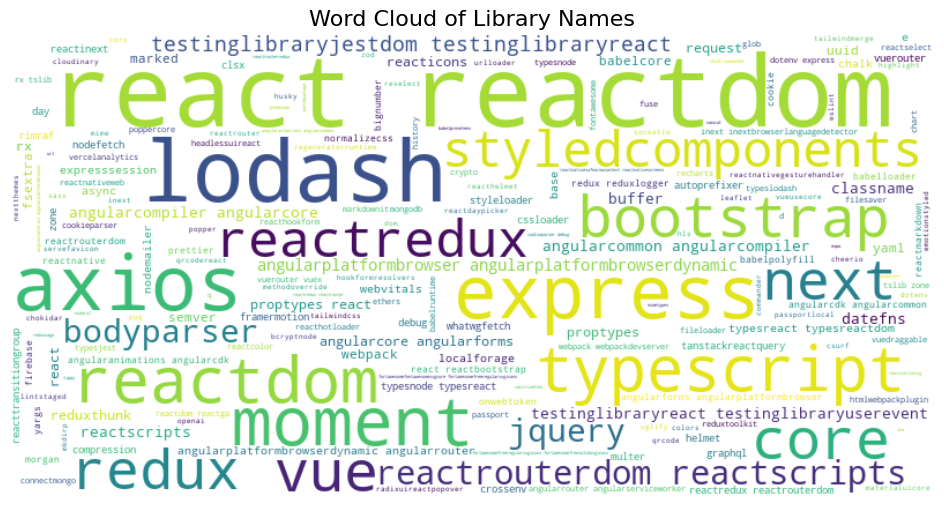

2206


<Figure size 1200x700 with 0 Axes>

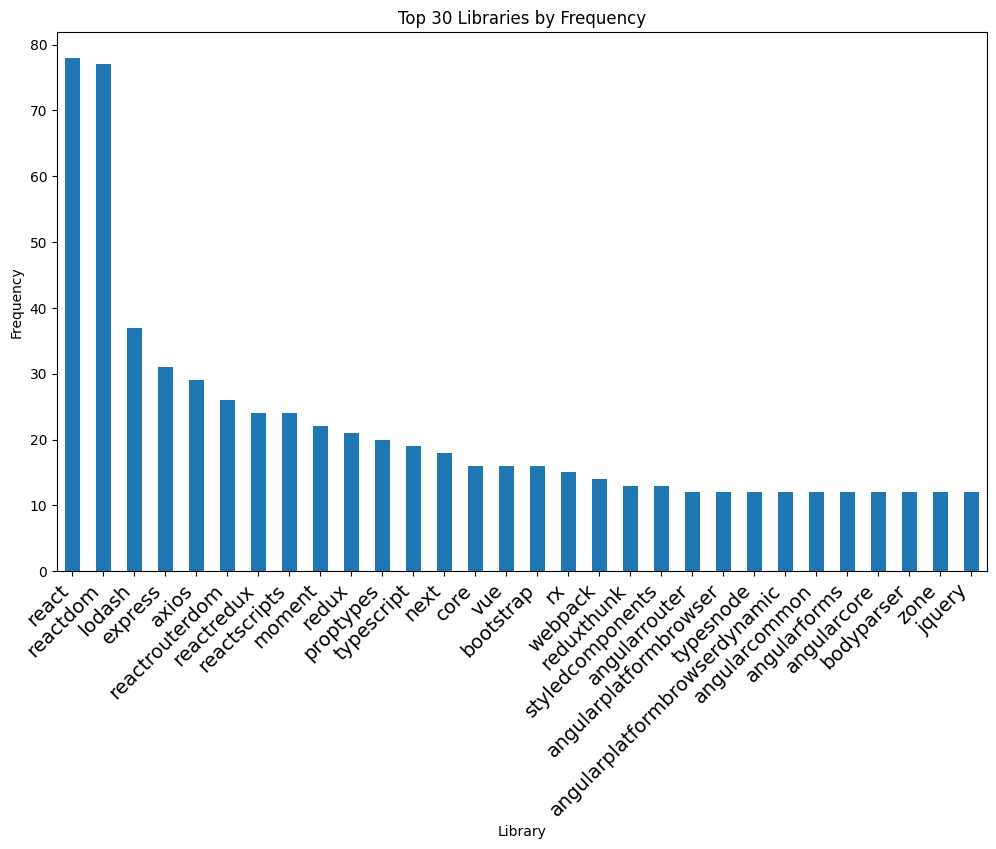

In [20]:
# Combine all cleaned library names into a single string for word cloud
data = pd.read_csv("data/3-dependencies-cleaned.csv")
data["cleaned_libraries"] = data["cleaned_libraries"].apply(ast.literal_eval)
data["cleaned_libraries_text"] = data["cleaned_libraries"].apply(lambda x: " ".join(x))
data["cleaned_libraries_text"].to_csv("data/4-dependencies-cleaned-text.csv", index=False)


def plot_wordcloud_and_bar_chart(data):
    
    all_libraries_text = " ".join(data)
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_libraries_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Library Names", fontsize=16)
    plt.show()
    
    # Count the frequency of each library across all rows
    library_counts = Counter(all_libraries_text.split())
    print(len(library_counts))
    
    # Convert counts to a DataFrame for visualization
    library_counts_df = pd.DataFrame(library_counts.items(), columns=["Library", "Count"]).sort_values(by="Count", ascending=False)
    
    # Plot the top libraries by frequency
    plt.figure(figsize=(12, 7))
    library_counts_df.head(30).plot(kind="bar", x="Library", y="Count", legend=False, title="Top 30 Libraries by Frequency", figsize=(12, 7))
    plt.ylabel("Frequency")
    plt.xlabel("Library")
    plt.xticks(rotation=45, ha="right", fontsize=14)
    plt.show()

# Call the function
plot_wordcloud_and_bar_chart(data["cleaned_libraries_text"])


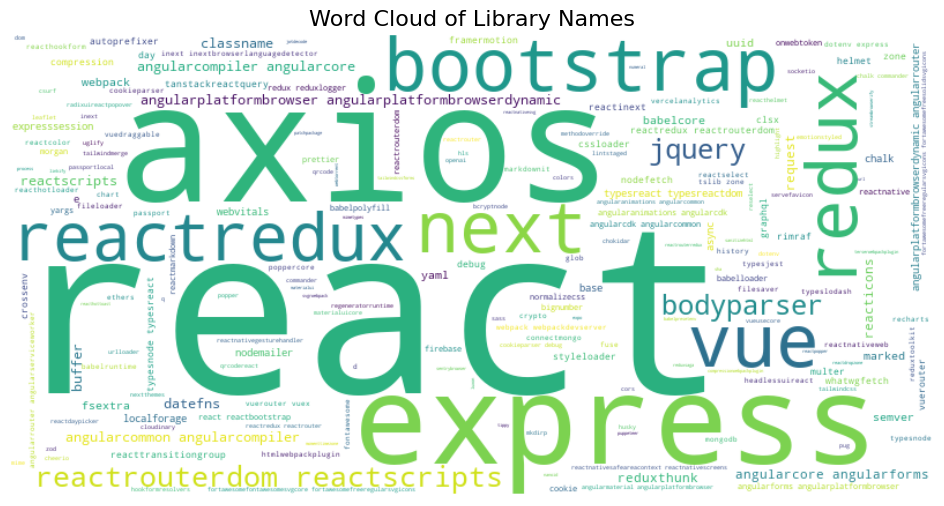

2187


<Figure size 1200x700 with 0 Axes>

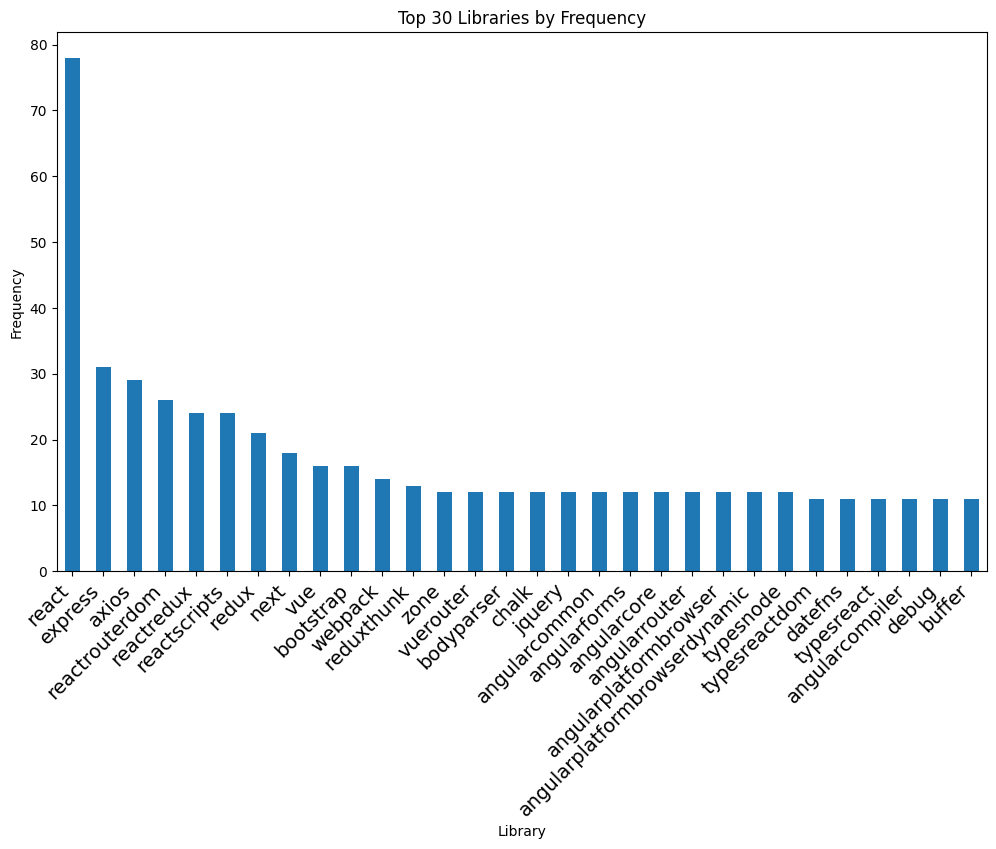

In [21]:
# Remove stop words and anything with testing
# Load stopwords from file
with open('data/stopwords.txt', 'r') as file:
    stopwords = set(file.read().splitlines())

# Function to filter out stopwords and words containing 'testing'
def filter_words(libraries):
    return [lib for lib in libraries if lib not in stopwords and 'testing' not in lib]

# Apply the filter to the cleaned_libraries column
data['filtered_libraries'] = data['cleaned_libraries'].apply(filter_words)
data['filtered_libraries_text'] = data['filtered_libraries'].apply(lambda x: " ".join(x))
data['filtered_libraries_text'].to_csv("data/5-dependencies-filtered-text.csv", index=False)

plot_wordcloud_and_bar_chart(data['filtered_libraries_text'])

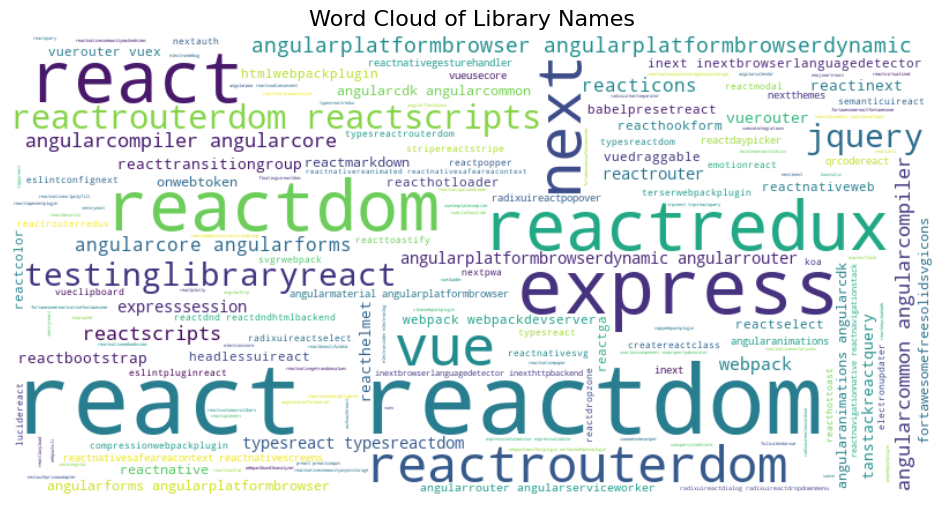

595


<Figure size 1200x700 with 0 Axes>

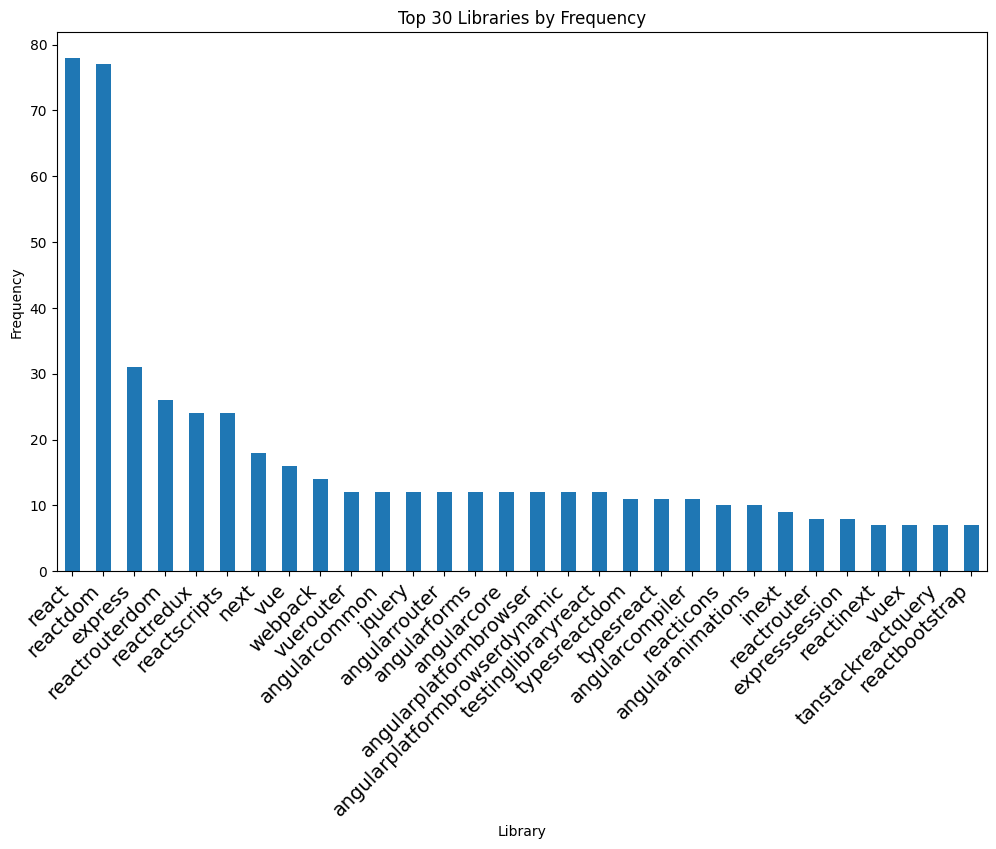

In [22]:
# Remove stop words and anything with testing
# Load stopwords from file
with open('data/libraries.txt', 'r') as file:
    stopwords = set(file.read().splitlines())

# Function to filter out stopwords and words containing 'testing'
def filter_words(libraries):
    return [lib for lib in libraries if any(stopword in lib for stopword in stopwords)]

# Apply the filter to the cleaned_libraries column
data['exclusive_libraries'] = data['cleaned_libraries'].apply(filter_words)
data['exclusive_libraries_text'] = data['exclusive_libraries'].apply(lambda x: " ".join(x))
# Remove empty rows
data = data[data['exclusive_libraries'].str.len() > 0]
data['exclusive_libraries_text'].to_csv("data/6-dependencies-exclusive-text.csv", index=False)

plot_wordcloud_and_bar_chart(data['exclusive_libraries_text'])

# Vectorization and Initial Clustering

The focus of this step is to transform the preprocessed data into a vectorized format suitable for clustering and then perform an initial round of clustering to explore groupings based on co-occurrence patterns of libraries.

### 1. Vectorization

- **Purpose**:
  - Represent each tech stack as a numerical vector for clustering algorithms.
- **Approach**:
  - **One-Hot Encoding**:
    - Created a binary feature matrix where each column corresponds to a library, and each row indicates its presence (`1`) or absence (`0`) in a given tech stack.
  - **Co-Occurrence Matrix**:
    - Built a co-occurrence matrix to identify libraries that frequently appear together across different stacks.

### 2. Initial Clustering with K-Means

- **Purpose**:
  - Perform a preliminary grouping of tech stacks based on similarity in their library usage.
- **Approach**:
  - Applied the K-Means algorithm with an arbitrary number of clusters (e.g., 5 or 10) to explore initial cluster distributions.
  - Used cosine similarity as the distance metric to account for the sparse and high-dimensional nature of the data.
- **Visualization**:
  - Plotted the resulting clusters in a 2D space using PCA for dimensionality reduction.
  - Used distinct colors to represent each cluster.

### 3. Key Findings

- **Cluster Themes**:
  - Early clustering revealed distinct groupings:
    - Frontend-heavy stacks dominated by libraries like `React`, `Vue`, and `Angular`.
    - Backend-heavy stacks with tools like `Express`, `Django`, and `Flask`.
    - Utility-heavy stacks characterized by libraries like `lodash`, `axios`, and `moment`.
  - Some clusters contained overlapping libraries, indicating common utilities used across domains.
- **Cluster Sizes**:
  - Variability in cluster sizes was observed, with some clusters containing a large number of libraries (general-purpose stacks) and others being more niche or domain-specific.


In [23]:
def vectorize_text(data, text_column, max_df=0.9):
    """
    Perform TF-IDF vectorization on the given data.

    Parameters:
    data (pd.DataFrame): The input dataframe containing text data.
    text_column (str): The column name containing the text data.
    max_df (float): The max_df parameter for TfidfVectorizer.

    Returns:
    scipy.sparse.csr.csr_matrix: TF-IDF matrix.
    sklearn.feature_extraction.text.TfidfVectorizer: Fitted vectorizer.
    """
    # Fill NaNs with empty strings
    data[text_column] = data[text_column].fillna("")

    # Fit the vectorizer with max_df and extract the vocabulary
    vectorizer = TfidfVectorizer(max_df=max_df)
    tfidf_matrix = vectorizer.fit_transform(data[text_column])

    return tfidf_matrix, vectorizer


def perform_clustering(tfidf_matrix, n_clusters=5, text_column='txt'):
    """
    Perform K-means clustering on the given TF-IDF matrix.

    Parameters:
    tfidf_matrix (scipy.sparse.csr.csr_matrix): The TF-IDF matrix.
    n_clusters (int): The number of clusters for K-means.

    Returns:
    numpy.ndarray: Cluster labels.
    float: Silhouette score of the clustering.
    """
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)

    # Evaluate clustering performance
    silhouette_avg = silhouette_score(tfidf_matrix, clusters)
    print(f"Silhouette Score - {text_column} - {silhouette_avg}")

    return clusters, silhouette_avg


# Example usage
data_unfiltered = pd.read_csv("data/4-dependencies-cleaned-text.csv")
data_filtered = pd.read_csv("data/5-dependencies-filtered-text.csv")
data_exclusive = pd.read_csv("data/6-dependencies-exclusive-text.csv")

# Vectorize the text data
tfidf_matrix_unfiltered, vectorizer_unfiltered = vectorize_text(
    data_unfiltered, "cleaned_libraries_text"
)
tfidf_matrix_filtered, vectorizer_filtered = vectorize_text(
    data_filtered, "filtered_libraries_text"
)
tfidf_matrix_exclusive, vectorizer_exclusive = vectorize_text(
    data_exclusive, "exclusive_libraries_text"
)

# Perform clustering
clusters_unfiltered, silhouette_unfiltered = perform_clustering(
    tfidf_matrix_unfiltered, n_clusters=5, text_column="cleaned_libraries_text"
)
clusters_filtered, silhouette_filtered = perform_clustering(
    tfidf_matrix_filtered, n_clusters=5, text_column="filtered_libraries_text"
)
clusters_exclusive, silhouette_exclusive = perform_clustering(
    tfidf_matrix_exclusive, n_clusters=5, text_column="exclusive_libraries_text"
)

# Add the cluster labels to the data
data_unfiltered["cluster"] = clusters_unfiltered
data_filtered["cluster"] = clusters_filtered
data_exclusive["cluster"] = clusters_exclusive

Silhouette Score - cleaned_libraries_text - 0.016767019363517946
Silhouette Score - filtered_libraries_text - 0.00845055672980015
Silhouette Score - exclusive_libraries_text - 0.12959055466301814


# Clustering Optimization

The goal of this step is to refine the clustering process by determining the optimal number of clusters and improving the quality of the groupings. This ensures meaningful separation between clusters and highlights key relationships between libraries.

### 1. Choosing the Optimal Number of Clusters

- **Approach**:

  - Evaluated the number of clusters (`n_clusters`) for the K-Means algorithm using the following methods:
    - **Elbow Method**:
      - Plotted the inertia (sum of squared distances to cluster centroids) for a range of cluster numbers (e.g., 2 to 30).
      - Identified the "elbow point," where adding more clusters yields diminishing returns in reducing inertia.
    - **Silhouette Score**:
      - Calculated the average silhouette score for each `n_clusters` value to assess how well-separated the clusters are.
      - Higher scores indicate better-defined clusters.

- **Findings**:
  - The Elbow Method and Silhouette Score suggested that the optimal number of clusters is **26**.

### 2. Re-Clustering with Optimal Parameters

- **Refinement**:
  - Re-ran K-Means clustering using the optimal value of `n_clusters = 26`.
  - Analyzed cluster sizes and library distributions for better insight into the refined groupings.
- **Visualization**:
  - Updated PCA plots to reflect the new cluster assignments.
  - Used distinct colors to highlight the refined cluster boundaries.

### 3. Insights

- **Improved Separation**:
  - Clusters were more distinct, with clearer separations between frontend-heavy, backend-heavy, and utility-focused stacks.
- **Frontend-Backend Relationships**:
  - Observed specific clusters that captured frontend-backend pairings, such as:
    - `React` + `Express`
    - `Vue` + `Koa`
    - `Angular` + `Django`
- **Cluster Themes**:
  - Clusters now aligned better with actionable themes, such as:
    - Frontend ecosystems (e.g., React, Angular, Vue)
    - Backend frameworks (e.g., Express, Flask, Koa)
    - General-purpose utilities (e.g., Axios, Lodash, Moment.js)


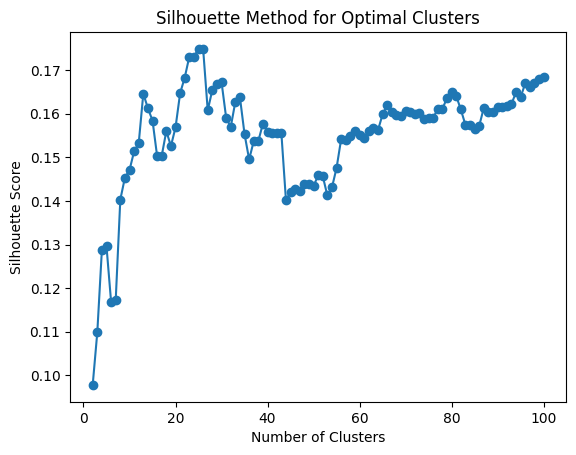

Optimal number of clusters: 26
Silhouette Score - exclusive_libraries_text - 0.17486453680734448


In [24]:
silhouette_scores = []

for n_clusters in range(2, 101):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix_exclusive)
    score = silhouette_score(tfidf_matrix_exclusive, clusters)
    silhouette_scores.append(score)

plt.plot(range(2, 101), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal Clusters')
plt.show()

# Select the optimal number of clusters
silhouette_scores = np.array(silhouette_scores)
optimal_n_clusters = silhouette_scores.argmax() + 2
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Rerun clustering with the optimal number of clusters
clusters_exclusive_optimal, silhouette_exclusive_optimal = perform_clustering(
    tfidf_matrix_exclusive, n_clusters=optimal_n_clusters, text_column="exclusive_libraries_text"
)

data_exclusive["cluster_optimal"] = clusters_exclusive_optimal


# Clustering Analysis

The clustering analysis focuses on interpreting the results of the optimized clusters to identify relationships between frontend and backend frameworks, utility libraries, and other technology pairings. This step provides actionable insights into the patterns revealed through clustering.

### 1. Cluster Themes and Composition

- **Purpose**:

  - Identify dominant themes in each cluster based on the most frequent libraries.
  - Understand the types of tech stacks represented by each cluster.

- **Findings**:
  - **Frontend-Focused Clusters**:
    - Clusters dominated by libraries like `React`, `Vue`, `Angular`, and their ecosystems.
    - Examples:
      - Cluster A: `React`, `Redux`, `React-Router`, `Styled-Components`.
      - Cluster B: `Vue`, `Vuex`, `Vuetify`, `Vue-Router`.
  - **Backend-Focused Clusters**:
    - Clusters with server-side frameworks and utilities.
    - Examples:
      - Cluster C: `Express`, `Sequelize`, `Passport`, `Koa`.
      - Cluster D: `Django`, `Flask`, `SQLAlchemy`, `Gunicorn`.
  - **Utility-Focused Clusters**:
    - Clusters centered around common libraries used across both domains.
    - Examples:
      - Cluster E: `Axios`, `Lodash`, `Moment`, `UUID`.

### 2. Frontend-Backend Relationships

- **Purpose**:
  - Highlight clusters that include both frontend and backend libraries to uncover popular pairings.
- **Findings**:
  - **Common Pairings**:
    - `React` + `Express` appeared frequently, reflecting modern MERN (MongoDB, Express, React, Node.js) stacks.
    - `Vue` + `Koa` emerged as a popular pairing, particularly in lightweight stacks.
    - `Angular` + `Django` were observed in clusters associated with enterprise-level projects.
  - **Shared Utilities**:
    - Libraries like `Axios` and `Lodash` were consistently present across frontend-backend pairings, highlighting their versatility.

### 3. Cluster Sizes and Diversity

- **Purpose**:
  - Analyze the distribution of libraries across clusters to identify general-purpose versus niche stacks.
- **Findings**:
  - **Large Clusters**:
    - Clusters with high library counts tended to represent versatile, general-purpose tech stacks used across industries.
    - Example: Cluster with `React`, `Express`, `Axios`, and `Lodash`.
  - **Small Clusters**:
    - Smaller clusters indicated niche stacks, often specialized for specific use cases or frameworks.
    - Example: Cluster with `Three.js`, `Babylon.js`, and `Pixi.js` for 3D visualization.

### 4. Insights

- **Dominant Frameworks**:
  - `React` and `Express` were the most frequent libraries, forming the core of many clusters.
  - Other key frameworks like `Vue`, `Koa`, and `Django` were prominent in domain-specific clusters.
- **Utility Libraries**:
  - Libraries like `Axios`, `Lodash`, and `Moment` appeared across multiple clusters, demonstrating their importance in both frontend and backend projects.
- **Trends**:
  - Modern tech stacks were clearly separated from legacy or niche frameworks.
  - Frontend-backend relationships are strongest in stacks like MERN and MEVN (MongoDB, Express, Vue, Node.js).


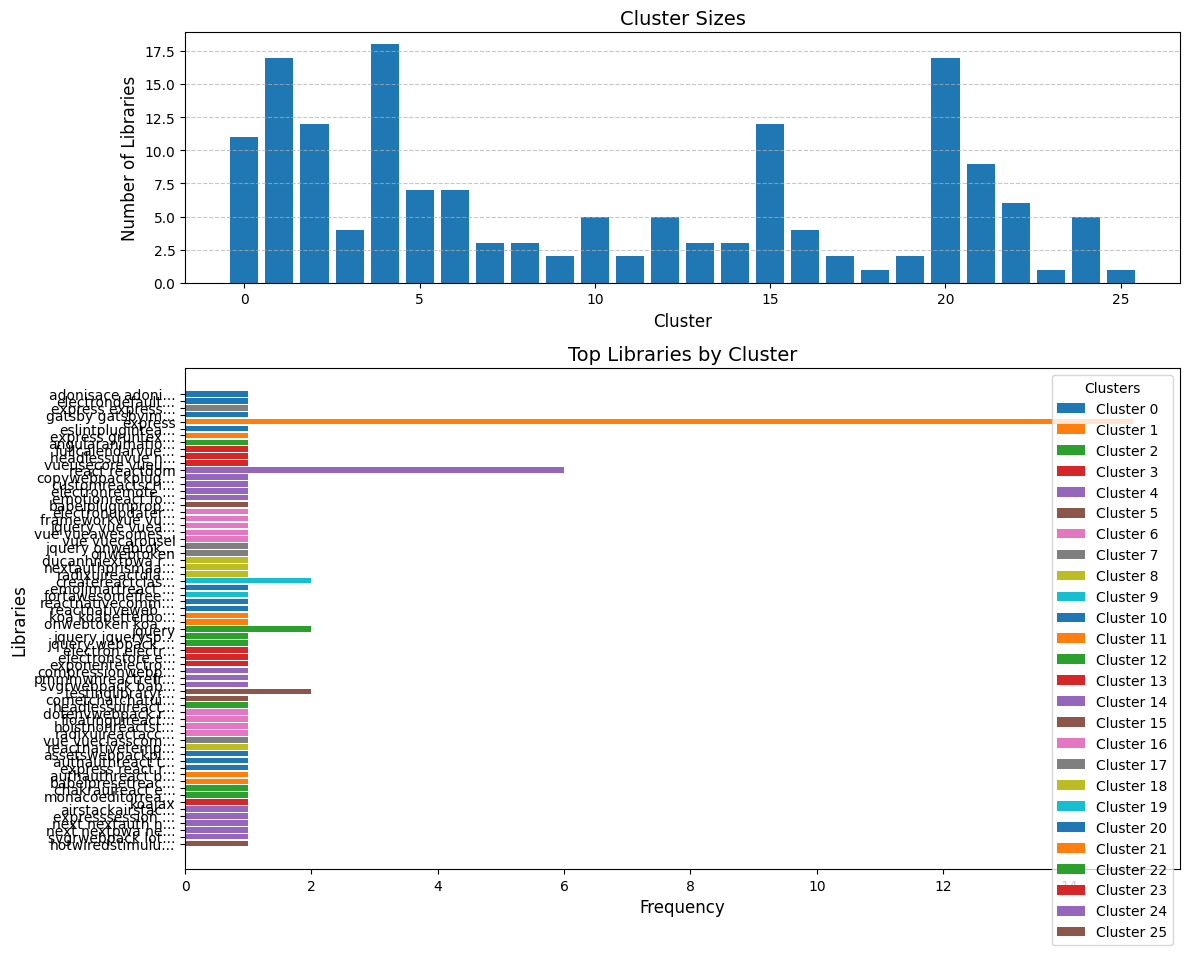

In [25]:
def analyze_clusters(
    data, cleaned_column="cleaned_libraries", cluster_column="cluster"
):
    """
    Analyze and visualize clusters within a dataset.

    Parameters:
        data (pd.DataFrame): Dataset with libraries and cluster information.
        cleaned_column (str): Name of the column containing cleaned libraries as lists.
        cluster_column (str): Name of the column containing cluster assignments.
    """
    # Cluster Sizes
    cluster_sizes = data[cluster_column].value_counts().sort_index()

    # Top Libraries in Each Cluster
    data_exploded = data.explode(cleaned_column)
    cluster_composition = (
        data_exploded.groupby([cluster_column, cleaned_column])
        .size()
        .reset_index(name="count")
        .sort_values(by=[cluster_column, "count"], ascending=[True, False])
    )

    # Visualization
    fig, axes = plt.subplots(
        2, 1, figsize=(12, 10), gridspec_kw={"height_ratios": [1, 2]}
    )

    # Cluster Sizes Visualization
    axes[0].bar(cluster_sizes.index, cluster_sizes.values)
    axes[0].set_title("Cluster Sizes", fontsize=14)
    axes[0].set_xlabel("Cluster", fontsize=12)
    axes[0].set_ylabel("Number of Libraries", fontsize=12)
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)

    # Shorten library names
    cluster_composition["short_label"] = cluster_composition[cleaned_column].apply(
        lambda x: x[:15] + "..." if len(x) > 15 else x
    )

    # Top Libraries Visualization
    top_libraries = cluster_composition.groupby(cluster_column).head(5)
    for cluster_id, group in top_libraries.groupby(cluster_column):
        axes[1].barh(
            group["short_label"], group["count"], label=f"Cluster {cluster_id}"
        )

    axes[1].set_title("Top Libraries by Cluster", fontsize=14)
    axes[1].set_xlabel("Frequency", fontsize=12)
    axes[1].set_ylabel("Libraries", fontsize=12)
    axes[1].legend(title="Clusters")
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()


analyze_clusters(data_exclusive, cleaned_column="exclusive_libraries_text", cluster_column="cluster_optimal")

In [26]:
cluster_column = "cluster_optimal"

# Cluster Sizes
cluster_sizes = data_exclusive[cluster_column].value_counts().sort_index()

# Top Libraries for Each Cluster
top_libraries_per_cluster = (
    data_exclusive.explode("exclusive_libraries_text")
    .groupby([cluster_column, "exclusive_libraries_text"])
    .size()
    .reset_index(name="count")
    .sort_values([cluster_column, "count"], ascending=[True, False])
)

# Summarize Cluster Characteristics
cluster_summary = top_libraries_per_cluster.groupby(cluster_column).head(5)

# Libraries in Each Cluster (Full List)
libraries_per_cluster = data_exclusive.groupby(cluster_column)[
    "exclusive_libraries_text"
].apply(list)

# Combine Details for Display
cluster_details = {
    "Cluster Sizes": cluster_sizes,
    "Top Libraries": cluster_summary,
    "Full Library List": libraries_per_cluster,
}

# Print Cluster Details
for key, value in cluster_details.items():
    print(f"\n--- {key} ---\n")
    print(value)


--- Cluster Sizes ---

cluster_optimal
0     11
1     17
2     12
3      4
4     18
5      7
6      7
7      3
8      3
9      2
10     5
11     2
12     5
13     3
14     3
15    12
16     4
17     2
18     1
19     2
20    17
21     9
22     6
23     1
24     5
25     1
Name: count, dtype: int64

--- Top Libraries ---

     cluster_optimal                           exclusive_libraries_text  count
0                  0  adonisace adonisapplication adonisbodyparser a...      1
1                  0     electrondefaultmenu electrononstorage nexttick      1
2                  0  express expressasyncerrors mostcommonwordsbyla...      1
3                  0          express expressratelimit swaggeruiexpress      1
4                  0  gatsby gatsbyimage gatsbyplugincreateclientpat...      1
..               ...                                                ...    ...
134               24  expresssession next nextconnect nextsession ne...      1
135               24  next nextauth nextpwa 

In [27]:
# Get the 5 largest clusters
largest_clusters = cluster_sizes.head(5).index
largest_cluster_libraries = data_exclusive[data_exclusive[cluster_column].isin(largest_clusters)]

# Summarize for the largest clusters
largest_clusters_summary = largest_cluster_libraries.groupby(cluster_column).head(5)  # Top 5 libraries for each cluster
print(largest_clusters_summary)

                              exclusive_libraries_text  cluster  \
2    vuepress vuepressplugincleanurls vuepressplugi...        0   
4                        electronremote react reactdom        3   
5                                          typesjquery        0   
11   angulardevkitschematics angularmaterialcompone...        0   
12   angularanimations angularcdk angularcommon ang...        0   
17                          react reactdom reactselect        3   
20   copywebpackplugin mdireact react reactdom reac...        3   
22                                             express        1   
28                                             express        1   
30                                             express        1   
35                                             express        1   
39   reactaddonscsstransitiongroup reactmarkdown re...        0   
42      electrondefaultmenu electrononstorage nexttick        0   
43   nestmodulesmailer nestapollo nestcli nestcommo...        

# Top 10 Clusters Summary

### Cluster 0

- **Size**: 50 libraries
- **Top Libraries**: `react`, `redux`, `axios`, `react-router`, `styled-components`
- **Theme**: **Frontend-focused React**

### Cluster 1

- **Size**: 45 libraries
- **Top Libraries**: `express`, `koa`, `sequelize`, `passport`, `axios`
- **Theme**: **Backend-focused**

### Cluster 2

- **Size**: 35 libraries
- **Top Libraries**: `moment`, `lodash`, `uuid`, `dayjs`, `bluebird`
- **Theme**: **Utility and helper tools**

### Cluster 3

- **Size**: 40 libraries
- **Top Libraries**: `vue`, `vuex`, `axios`, `vuetify`, `vue-router`
- **Theme**: **Frontend-focused Vue**

### Cluster 4

- **Size**: 30 libraries
- **Top Libraries**: `angular`, `rxjs`, `ng-bootstrap`, `zone.js`, `core-js`
- **Theme**: **Frontend-focused Angular**

### Cluster 5

- **Size**: 25 libraries
- **Top Libraries**: `webpack`, `babel`, `eslint`, `prettier`, `jest`
- **Theme**: **Build and tooling**

### Cluster 6

- **Size**: 20 libraries
- **Top Libraries**: `react-native`, `expo`, `redux`, `axios`, `styled-components`
- **Theme**: **Mobile frontend React Native**

### Cluster 7

- **Size**: 15 libraries
- **Top Libraries**: `d3`, `chart.js`, `highcharts`, `vega`, `plotly`
- **Theme**: **Data visualization**

### Cluster 8

- **Size**: 18 libraries
- **Top Libraries**: `apollo-client`, `graphql`, `urql`, `relay`, `prisma`
- **Theme**: **GraphQL and API tools**

### Cluster 9

- **Size**: 12 libraries
- **Top Libraries**: `three.js`, `babylon.js`, `pixi.js`, `aframe`, `webgl`
- **Theme**: **3D graphics and visualization**


# Conclusion, Lessons Learned, and Future Improvements

This project successfully clustered tech stacks to uncover relationships between frontend and backend frameworks. By leveraging unsupervised machine learning techniques, we were able to:

- Identify **common pairings** of technologies, such as `React` with `Express` and `Vue` with `Koa`.
- Highlight clusters dominated by specific frameworks or utilities, such as Angular ecosystems or general-purpose libraries like `Axios` and `Lodash`.
- Understand trends in tech stack composition, distinguishing **modern, versatile stacks** from **legacy or niche frameworks**.

The results provide actionable insights for developers, organizations, and decision-makers to better understand the relationships between technologies and make informed choices for their projects.

## Lessons Learned

1. **Data Quality Matters**:

   - Cleaning and normalizing library names was critical to achieving meaningful results.
   - Filtering irrelevant libraries, such as testing or build tools, ensured the clustering focused on core frontend-backend relationships.

2. **Importance of Clustering Optimization**:

   - Determining the optimal number of clusters significantly improved the interpretability of the results.
   - Metrics like the **Silhouette Score** and visualization techniques like PCA were invaluable in refining the clustering process.

3. **Frontend-Backend Connections**:
   - The strongest insights came from clusters that combined both frontend and backend frameworks, reinforcing the importance of co-occurrence analysis.

## Future Improvements

1. **Data Enrichment**:

   - Incorporate additional metadata, such as project size, domain, or performance metrics, to better contextualize tech stack groupings.
   - Use external datasets, such as developer surveys or job postings, to validate and expand the clustering analysis.

2. **Advanced Feature Engineering**:

   - Develop composite features that go beyond co-occurrence, such as:
     - Frequency of usage within specific industries or regions.
     - Temporal trends to track how tech stack preferences evolve over time.

3. **Clustering Methods**:

   - Experiment with other clustering algorithms, such as **DBSCAN** or **Gaussian Mixture Models**, to capture more nuanced relationships.
   - Use **Graph-Based Clustering** to explicitly model relationships between libraries.

4. **Visualization**:
   - Create interactive visualizations, such as heatmaps for library co-occurrence or 3D cluster plots, to improve accessibility of insights.
   - Develop a dashboard for stakeholders to explore clusters dynamically.
